# Imports

In [ ]:
import pandas as pd
import datetime
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import contextily as ctx
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

# Data Description

| Column        | Description |
| ------------- | ------------- |
| opendata_id  | Primary key |
| longitude    | Geolocation of the business, described by the longitude (Format: EPSG 4326) |
| latitude     | Geolocation of the business, described by the latitude (Format: EPSG 4326) |
| postcode     | Postcode of the business |
| city         | City of the business |
| Bezirk       | Bezirk of the business |
| Ortsteil     | Ortsteil of the business |
| Prognoseraum    | LOR Prognoseraum  |
| Bezirksregion  | LOR Bezirksregion |
| Planungsraum    | LOR Planungsraum |
| planungsraum_id    | LOR Planungsraum ID |
| ihk_branch_id  | Branch ID of the business as defined by IHK classification of economic activities (finest granuality of distinction), see [IHK Wirtschaftszweige](https://www.ihk.de/blueprint/servlet/resource/blob/5186288/c8bb510197a45c71b59b7a27cdc31bcb/wzbra-wahlgruppen-fit-data.pdf) |
| ihk_branch_desc    | Branch description of the business as defined by IHK classification of economic activities|
| nace_id  | Branch ID of the business as defined by EU classification of economic activities, see [NACE-Codes](https://nacev2.com/de) |
| nace_desc    | Branch description of the business as defined by EU classification of economic activities|
| branch_top_level_id  | Branch ID of the business as a broad classification of economic activities|
| branch_top_level_desc    | Branch description of the business as a broad classification of economic activities |
| employees_range  | The reported number of employees as range  |
| business_age    | Current age of the business |
| business_type  | "Kleingewerbetreibender" = the business is a small trader, "im Handelsregister eingetragen" = the business is registered in the Commercial Register  |

In [2]:
# Letzten Commit der CSV abrufen
IHK_REPO_URL = "https://api.github.com/repos/IHKBerlin/IHKBerlin_Gewerbedaten/commits"

response = requests.get(IHK_REPO_URL, params={"path": "data/IHKBerlin_Gewerbedaten.csv", "per_page": 1}).json()

last_commit = response[0]["commit"]["committer"]["date"]
IHK_GEWERBEDATEN_DATE = datetime.datetime.strptime(last_commit, "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m-%d")

print("Die CSV von der IHK wurde zuletzt bearbeitet am:", IHK_GEWERBEDATEN_DATE)

Die CSV von der IHK wurde zuletzt bearbeitet am: 2025-02-01


In [3]:
#CSV_URL = "https://github.com/IHKBerlin/IHKBerlin_Gewerbedaten/blob/master/data/IHKBerlin_Gewerbedaten.csv?raw=true"
#df = pd.read_csv(CSV_URL)
df = pd.read_csv("../input/IHKBerlin_Gewerbedaten.csv")
df.name = "Main DataFrame"
df.head()

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
0        572114  Berlin     10179  52.513315  13.411584        65122.0   
1       6063606  Berlin     10713  52.488737  13.302834       562900.0   
2     131831318  Berlin     10713  52.479296  13.319051        47430.0   
3  943032071440  Berlin     12047  52.486200  13.429312       731108.0   
4  927439271464  Berlin     12435  52.492207  13.451324       451103.0   

   nace_id  branch_top_level_id     employees_range  \
0   6512.0                 65.0      0 Beschäftigte   
1   5629.0                 56.0      0 Beschäftigte   
2   4743.0                 47.0      0 Beschäftigte   
3   7311.0                 73.0      0 Beschäftigte   
4   4511.0                 45.0  1 - 3 Beschäftigte   

                             ihk_branch_desc  \
0           Schaden- u. Unfallversicherungen   
1                                   Kantinen   
2  EH m. Geräten der Unterhaltungselektronik   
3                  Promotion, Propagandisten   
4   EH m. Elektro-, Gas- u. Hybridfahrzeugen   

                                           nace_desc  \
0                          Nichtlebensversicherungen   
1  Erbringung sonstiger Verpflegungsdienstleistungen   
2          EH m. Geräten der Unterhaltungselektronik   
3                                     Werbeagenturen   
4  Handel m. Kraftwagen mit einem Gesamtgewicht v...   

                               branch_top_level_desc  business_age  \
0  Versicherungen, Rückversicherungen u. Pensions...          40.0   
1                                        Gastronomie          41.0   
2     Einzelhandel (ohne Handel mit Kraftfahrzeugen)          40.0   
3                          Werbung u. Marktforschung          13.0   
4  Handel mit Kraftfahrzeugen; Instandhaltung u. ...          10.0   

                    business_type                      Bezirk  \
0          Kleingewerbetreibender                       Mitte   
1          Kleingewerbetreibender  Charlottenburg-Wilmersdorf   
2          Kleingewerbetreibender  Charlottenburg-Wilmersdorf   
3  im Handelsregister eingetragen                    Neukölln   
4          Kleingewerbetreibender            Treptow-Köpenick   

   planungsraum_id        Planungsraum          Bezirksregion  \
0        1100312.0  Heine-Viertel West         Alexanderplatz   
1        4500939.0     Eisenzahnstraße               Halensee   
2        4501148.0     Brabanter Platz  Volkspark Wilmersdorf   
3        8100314.0         Donaustraße           Reuterstraße   
4        9100101.0         Alt-Treptow            Alt-Treptow   

          Prognoseraum     Ortsteil  
0              Zentrum        Mitte  
1  Wilmersdorf Zentrum  Wilmersdorf  
2  Wilmersdorf Zentrum  Wilmersdorf  
3             Neukölln     Neukölln  
4   Treptow-Köpenick 1  Alt-Treptow

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366089 entries, 0 to 366088
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   opendata_id            366089 non-null  int64  
 1   city                   366089 non-null  object 
 2   postcode               366089 non-null  int64  
 3   latitude               366089 non-null  float64
 4   longitude              366089 non-null  float64
 5   ihk_branch_id          366015 non-null  float64
 6   nace_id                366015 non-null  float64
 7   branch_top_level_id    366015 non-null  float64
 8   employees_range        366089 non-null  object 
 9   ihk_branch_desc        366013 non-null  object 
 10  nace_desc              365746 non-null  object 
 11  branch_top_level_desc  365794 non-null  object 
 12  business_age           365190 non-null  float64
 13  business_type          366089 non-null  object 
 14  Bezirk                 366077 non-nu

# EDA

In [5]:
df.describe()

opendata_id      postcode       latitude      longitude  \
count  3.660890e+05  3.660890e+05  366089.000000  366089.000000   
mean   7.643104e+11  1.183061e+04      52.505273      13.386858   
std    3.034100e+12  2.176064e+03       0.046503       0.093876   
min    5.721140e+05  1.011500e+04      48.138039       6.672843   
25%    1.065714e+11  1.058700e+04      52.479325      13.324440   
50%    1.918686e+11  1.205500e+04      52.506816      13.387176   
75%    1.132095e+12  1.308600e+04      52.533777      13.437797   
max    6.816592e+13  1.055787e+06      52.765096      14.556583   

       ihk_branch_id        nace_id  branch_top_level_id   business_age  \
count   3.660150e+05  366015.000000        366015.000000  365190.000000   
mean    8.656614e+05    6386.112334            63.958630       9.375736   
std     2.002241e+06    1779.908387            17.059238       9.576796   
min     0.000000e+00       0.000000             0.000000       0.000000   
25%     5.621000e+04    4791.000000            47.000000       2.000000   
50%     8.551000e+04    6420.000000            66.000000       7.000000   
75%     6.820260e+05    7490.000000            74.000000      13.000000   
max     9.609094e+06    9999.000000            99.000000     100.000000   

       planungsraum_id  
count     3.660770e+05  
mean      5.569994e+06  
std       3.351341e+06  
min       1.100101e+06  
25%       2.500833e+06  
50%       4.501045e+06  
75%       8.100209e+06  
max       1.260124e+07

Die einzige statischer relevante Wert ist business_age, alle anderen sind IDs mehr oder weniger

## Missing-Values

In [6]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts

business_age             899
nace_desc                343
branch_top_level_desc    295
ihk_branch_desc           76
branch_top_level_id       74
ihk_branch_id             74
nace_id                   74
Ortsteil                  22
Bezirk                    12
planungsraum_id           12
Planungsraum              12
Bezirksregion             12
Prognoseraum              12
employees_range            0
longitude                  0
city                       0
latitude                   0
postcode                   0
business_type              0
opendata_id                0
dtype: int64

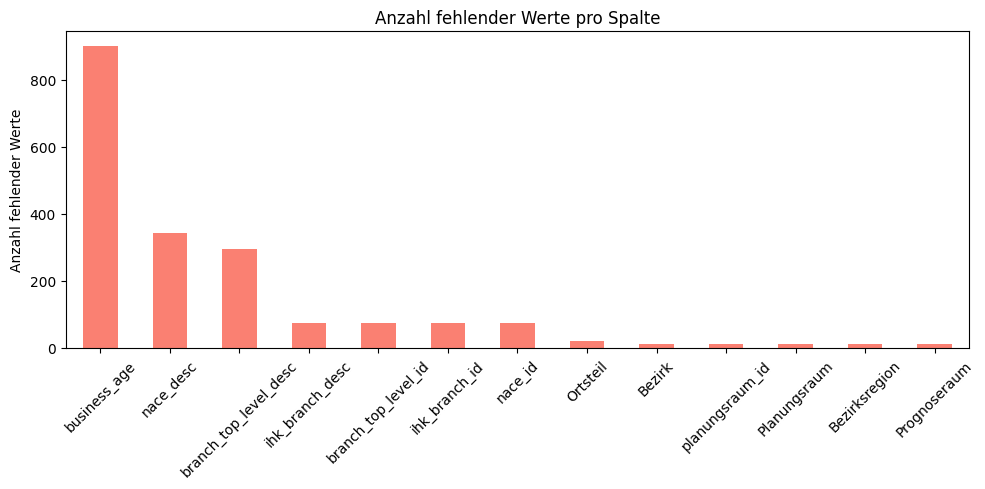

In [7]:
plt.figure(figsize=(10, 5))
missing_counts[missing_counts > 0].plot(kind='bar', color='salmon')
plt.ylabel("Anzahl fehlender Werte")
plt.title("Anzahl fehlender Werte pro Spalte")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- NACE und Branch top level haben viele fehlende Werte, daher erstmal für weitere Analysen IHK Branche in betracht ziehen, wenn dieser nicht zu granular ist
- Anscheint sind einige Unternehmen nicht in Berlin? Warum sind die aber in den Datensatz?

## Categorical Columns

In [8]:
categorical_columns = [
    "city",
    "Bezirk",
    "Ortsteil",
    "Prognoseraum",
    "Bezirksregion",
    "Planungsraum",
    "ihk_branch_desc", 
    "nace_desc",
    "branch_top_level_desc",
    "employees_range",
    "business_type"
]

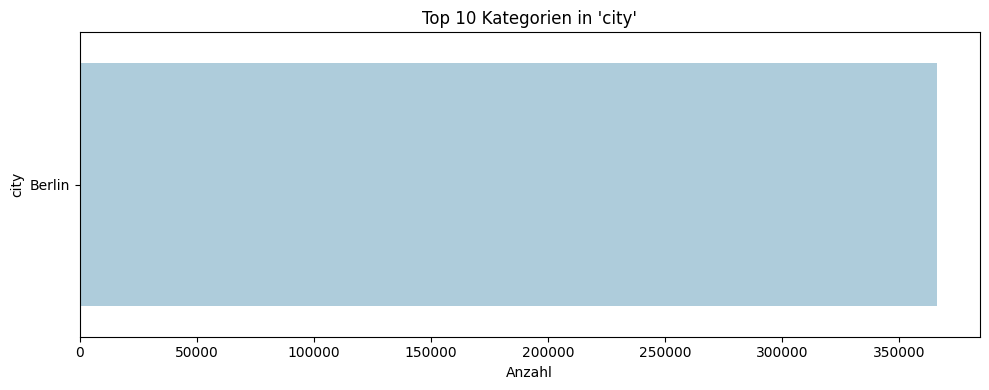

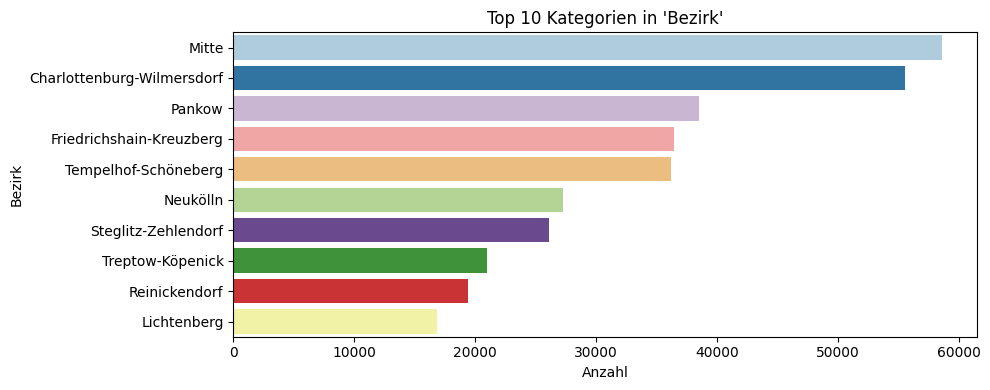

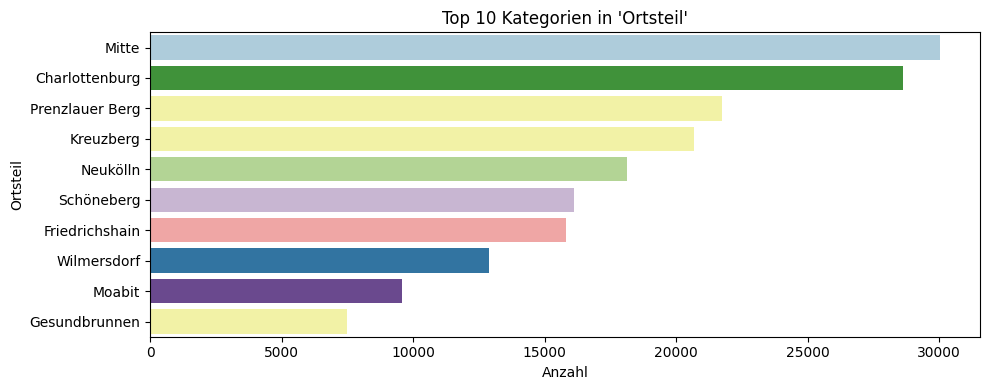

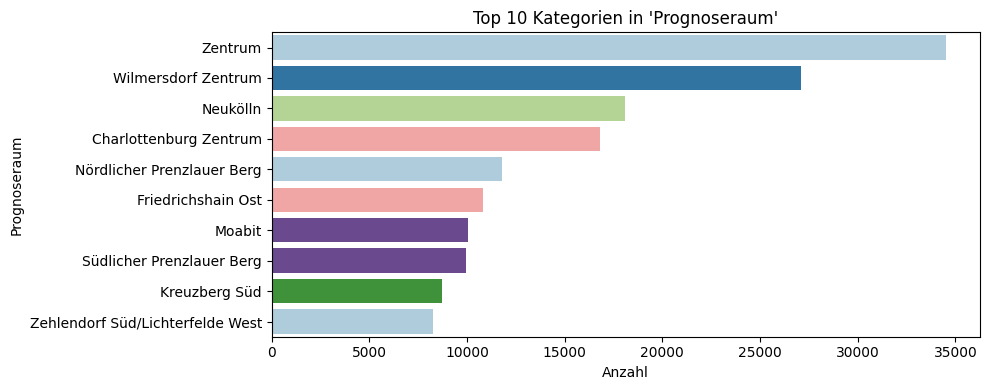

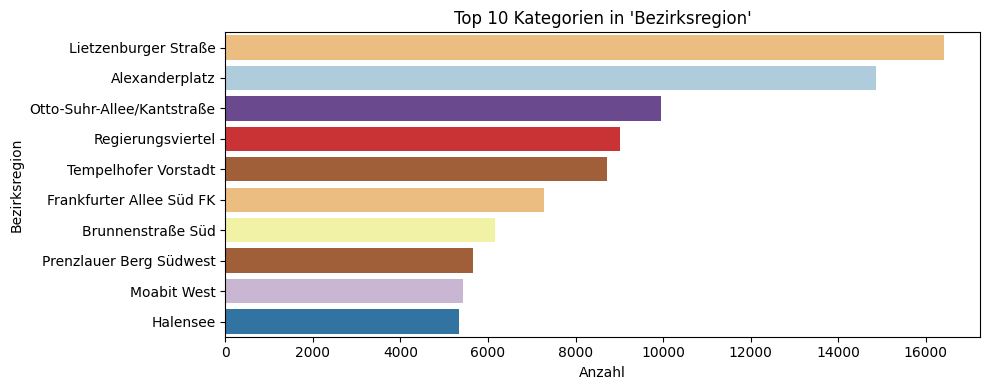

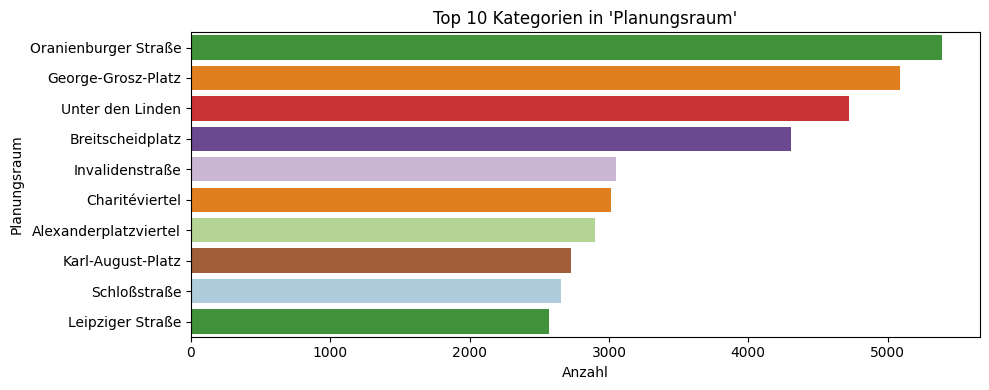

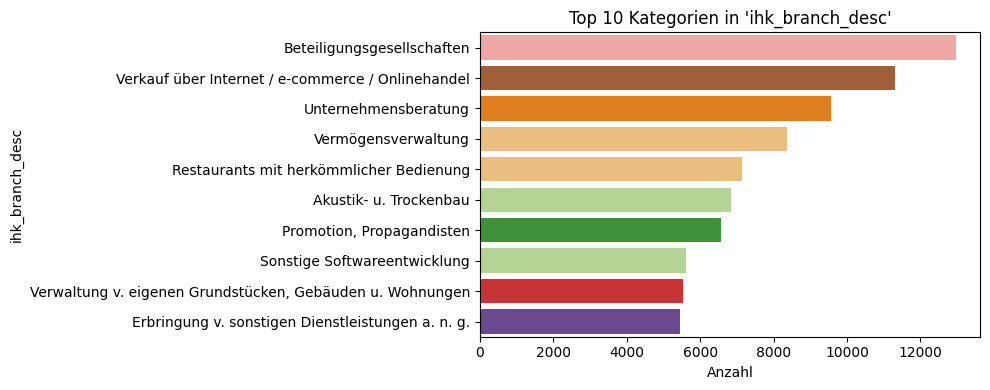

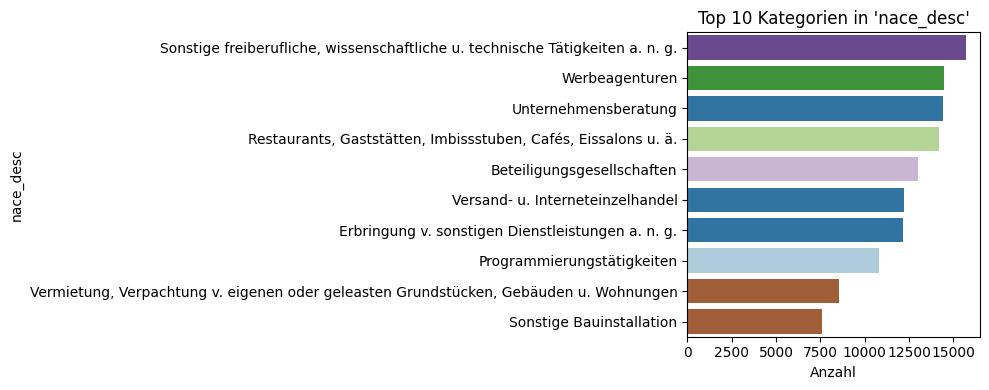

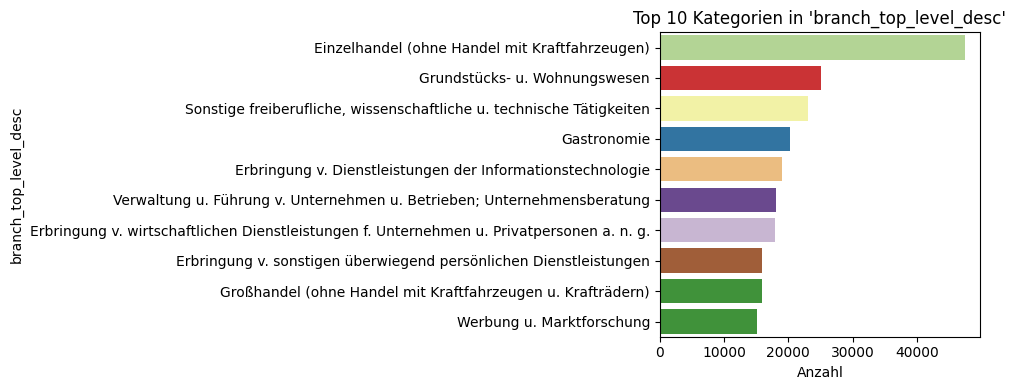

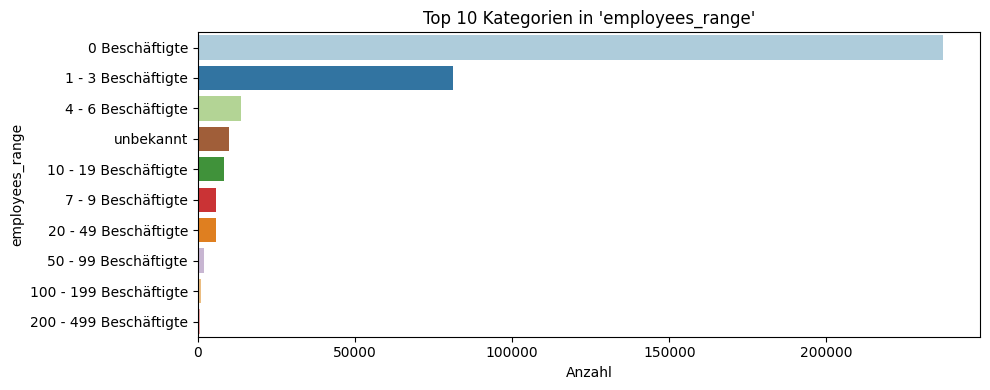

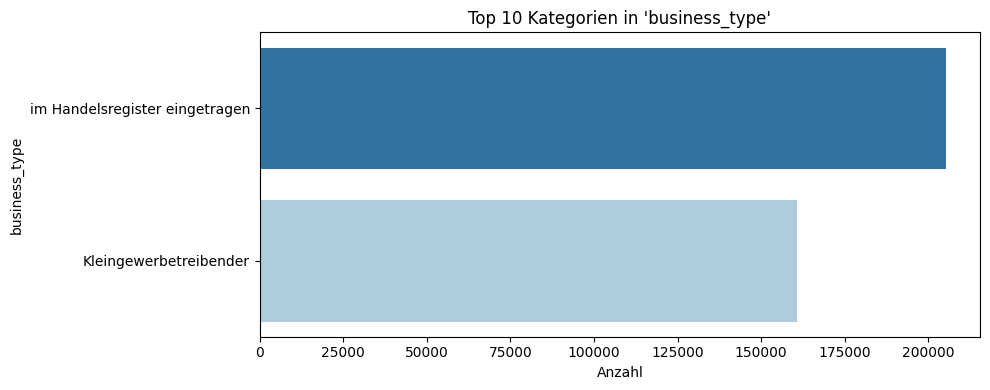

In [9]:
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    order = df[col].value_counts().index[:10]
    ax = sns.countplot(data=df, y=col, order=order, hue=col, palette="Paired", dodge=False, legend=False)
    plt.title(f"Top 10 Kategorien in '{col}'")
    plt.xlabel("Anzahl")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


- alle Unternehmen sind in Berlin geschlüsselt
- durch die Darstellung der Bezirge und co. erkennt man stark, dass der "KuDamm" sehr Unternehmensreich ist
- Die unterschiedlichen Branchen varieren sehr stark!
    - nace hat als häufigstes "sonstiges" -> nicht so gut
    - bei branch top level ist eine starke Verteilung auf Einzelhandel -> zu allgemein
    - daher in zukunft ihk branch nutzen
- 0 Beschäfigte als häufigstes --> deutet daraufhin, dass viele als Einzelunternhemen ohne Mitarbeit tätig sind

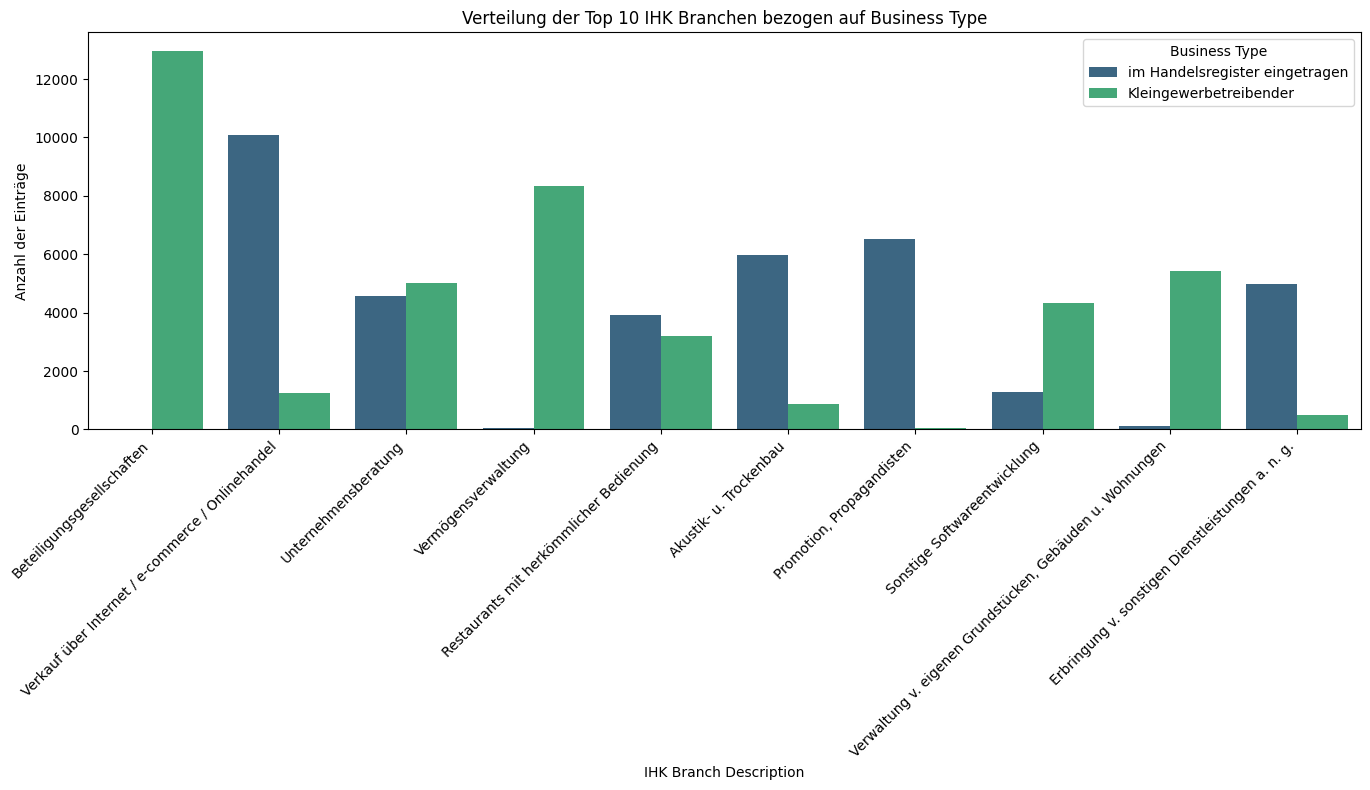

In [10]:
# Ermitteln der Top 10 IHK-Branchen (ihk_branch_desc) basierend auf ihrer Häufigkeit
top10_branches = df['ihk_branch_desc'].value_counts().nlargest(10).index

# Filtern des DataFrames, sodass nur Zeilen mit den Top 10 IHK-Branchen enthalten sind
df_top10 = df[df['ihk_branch_desc'].isin(top10_branches)]

# Erstellen des Balkendiagramms
plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_top10, 
    x='ihk_branch_desc', 
    hue='business_type', 
    order=top10_branches, 
    palette="viridis"
)
plt.xlabel("IHK Branch Description")
plt.ylabel("Anzahl der Einträge")
plt.title("Verteilung der Top 10 IHK Branchen bezogen auf Business Type")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Business Type")
plt.tight_layout()
plt.show()

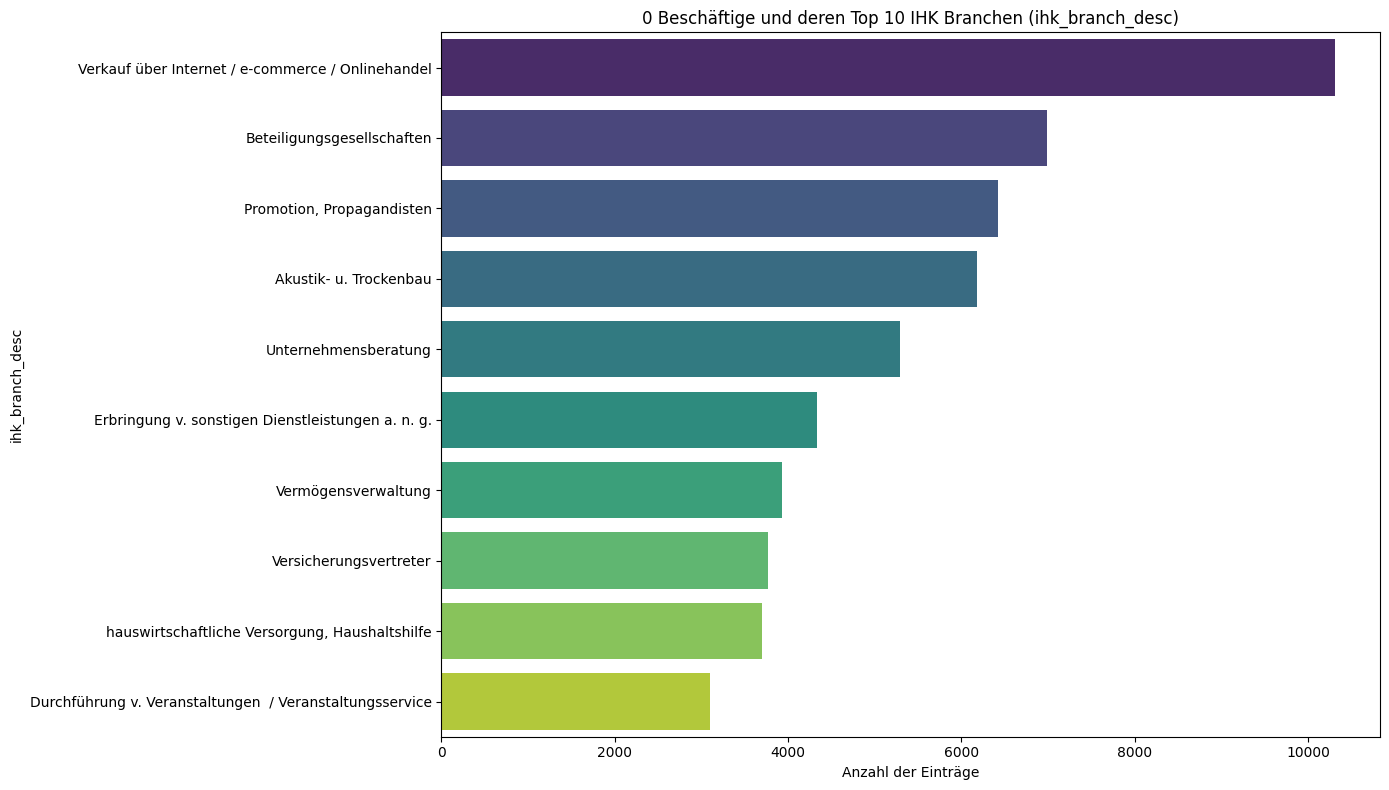

In [11]:
df_0besch = df[df["employees_range"] == "0 Beschäftigte"]

temp_df = df_0besch['ihk_branch_desc'].value_counts().head(10).reset_index()
temp_df.columns = ['ihk_branch_desc', 'Count']

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=temp_df,
    x='Count',
    y='ihk_branch_desc',
    hue='ihk_branch_desc',
    dodge=False,
    palette="viridis"
)

plt.xlabel("Anzahl der Einträge")
plt.ylabel("ihk_branch_desc")
plt.title("0 Beschäftige und deren Top 10 IHK Branchen (ihk_branch_desc)")
plt.tight_layout()
plt.show()

## business_age

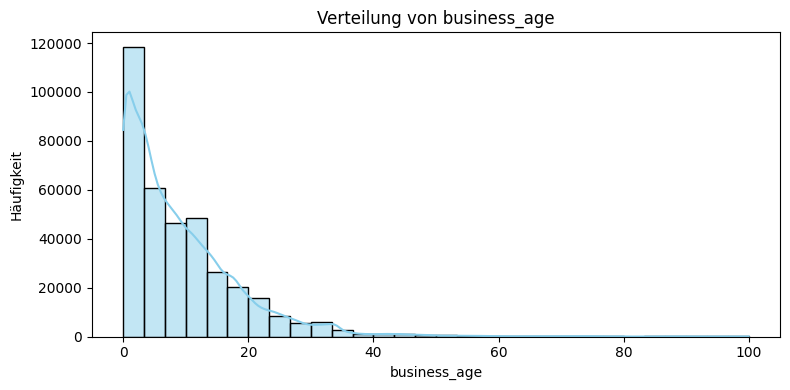

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df["business_age"], kde=True, bins=30, color='skyblue')
plt.title(f"Verteilung von business_age")
plt.xlabel("business_age")
plt.ylabel("Häufigkeit")
plt.tight_layout()
plt.show()

# Data Cleaning

- Umgang mit fehlenden Daten (Imputation).
- Entfernung oder Umgang mit Ausreißern.
- Codierung kategorischer Variablen (z. B. One-Hot-Encoding, Label-Encoding).
- Skalierung und Normalisierung der Daten.

In [13]:
def visualize_nan(df, column_name):
    nan_count = df[column_name].isna().sum()

    plt.figure(figsize=(6, 4))
    bars = plt.bar([column_name], [nan_count], color='skyblue')
    plt.bar([column_name], [nan_count], color='skyblue')
    plt.ylabel("Anzahl der NaNs")
    plt.title(f"NaN-Werte in Spalte {column_name} von: {df.name}")

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{int(height)}', 
            ha='center', 
            va='bottom'
        )

    plt.tight_layout()
    plt.show()

## opendata_id

In [14]:
df[df.duplicated(subset="opendata_id")].value_counts()

Series([], Name: count, dtype: int64)

## postcode

Die gültigen PLZ in Berlin befinden sich von 10115 bis 14199

In [15]:
df[(df["postcode"] < 10115) | (df["postcode"] > 14199)]

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
127098  93377167572  Berlin   1055787  52.515739  13.316621         9609.0   

        nace_id  branch_top_level_id employees_range  \
127098   9609.0                 96.0  0 Beschäftigte   

                                          ihk_branch_desc  \
127098  Erbringung v. sonstigen Dienstleistungen a. n. g.   

                                                nace_desc  \
127098  Erbringung v. sonstigen Dienstleistungen a. n. g.   

                                    branch_top_level_desc  business_age  \
127098  Erbringung v. sonstigen überwiegend persönlich...          15.0   

                         business_type                      Bezirk  \
127098  im Handelsregister eingetragen  Charlottenburg-Wilmersdorf   

        planungsraum_id        Planungsraum               Bezirksregion  \
127098        4300622.0  Ernst-Reuter-Platz  Otto-Suhr-Allee/Kantstraße   

                  Prognoseraum        Ortsteil  
127098  Charlottenburg Zentrum  Charlottenburg

Bezogen auf die latitude und longitude wäre das folgende PLZ: 10587

ID: 93377167572

In [16]:
df.loc[(df["postcode"] < 10115) | (df["postcode"] > 14199), "postcode"] = 10587
df[df["opendata_id"] == 93377167572]

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
127098  93377167572  Berlin     10587  52.515739  13.316621         9609.0   

        nace_id  branch_top_level_id employees_range  \
127098   9609.0                 96.0  0 Beschäftigte   

                                          ihk_branch_desc  \
127098  Erbringung v. sonstigen Dienstleistungen a. n. g.   

                                                nace_desc  \
127098  Erbringung v. sonstigen Dienstleistungen a. n. g.   

                                    branch_top_level_desc  business_age  \
127098  Erbringung v. sonstigen überwiegend persönlich...          15.0   

                         business_type                      Bezirk  \
127098  im Handelsregister eingetragen  Charlottenburg-Wilmersdorf   

        planungsraum_id        Planungsraum               Bezirksregion  \
127098        4300622.0  Ernst-Reuter-Platz  Otto-Suhr-Allee/Kantstraße   

                  Prognoseraum        Ortsteil  
127098  Charlottenburg Zentrum  Charlottenburg

## latitude & longitude

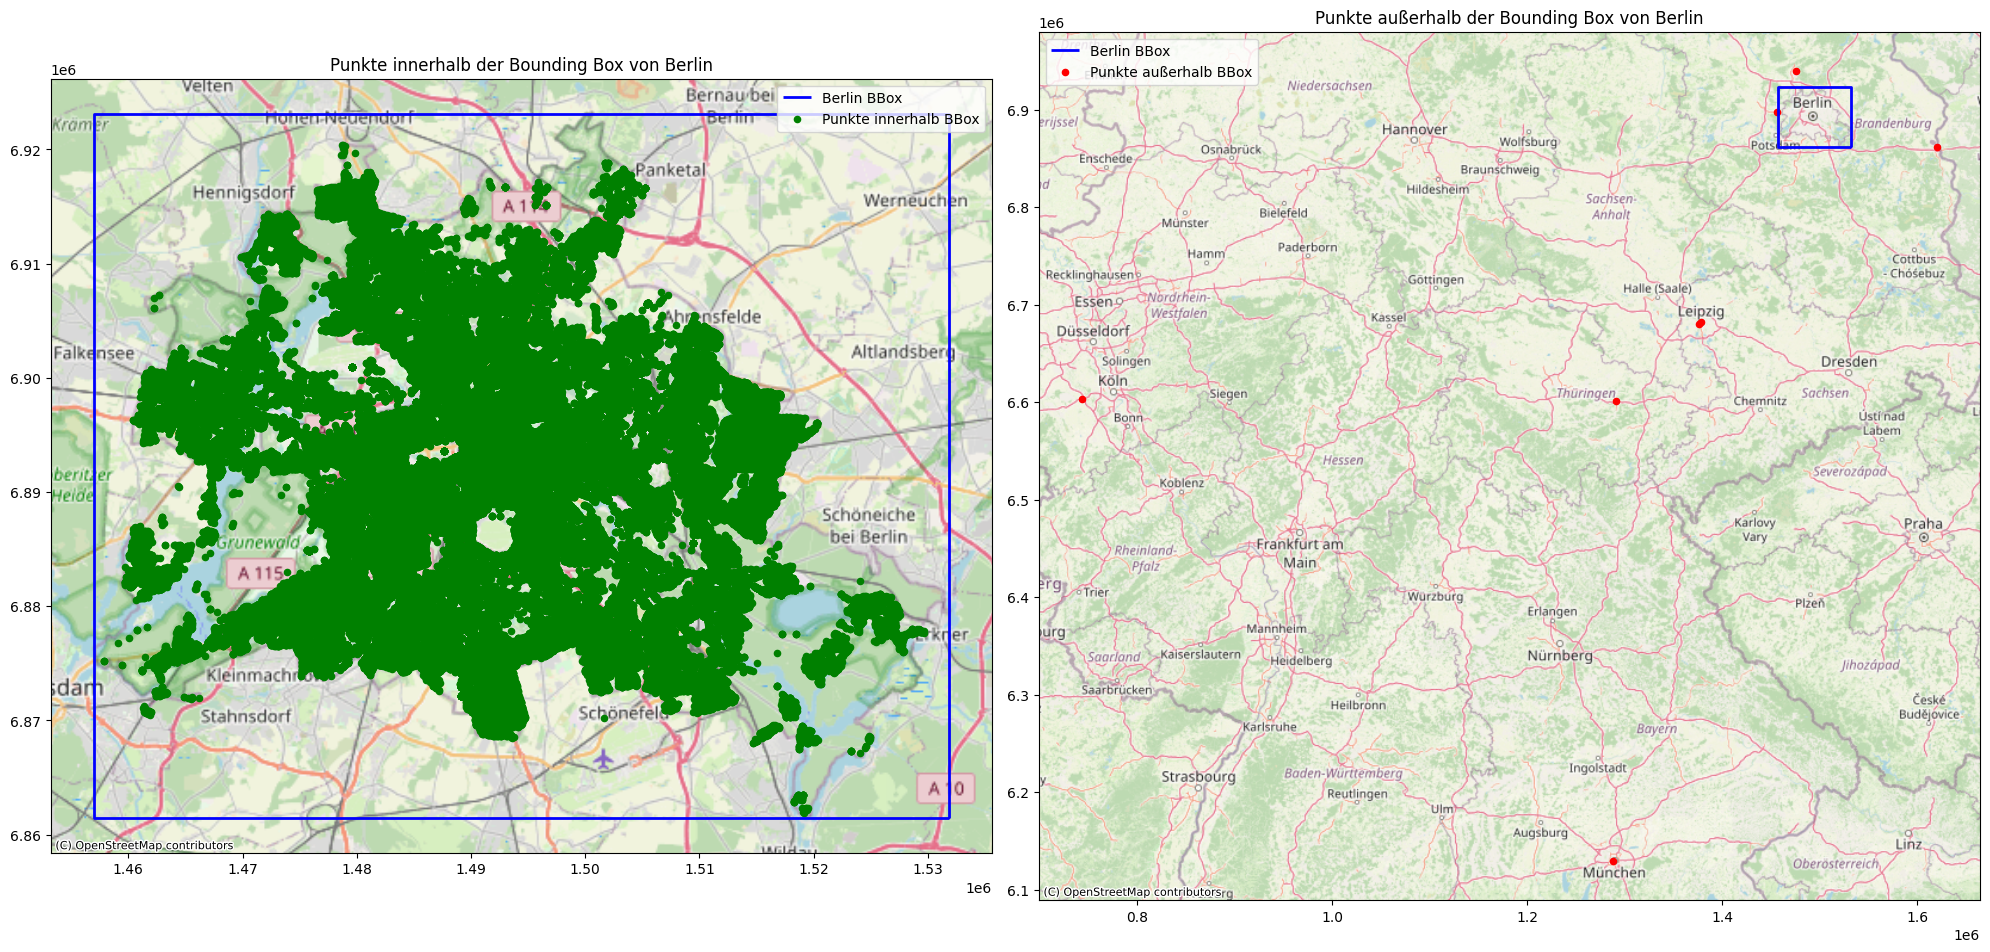

In [17]:
min_lon, min_lat = 13.088, 52.338
max_lon, max_lat = 13.761, 52.675
berlin_bbox = box(min_lon, min_lat, max_lon, max_lat)

inside_berlin = df[
    (df['longitude'] >= min_lon) & (df['longitude'] <= max_lon) &
    (df['latitude']  >= min_lat)  & (df['latitude']  <= max_lat)
]

outside_berlin = df[
    (df['longitude'] < min_lon) | (df['longitude'] > max_lon) |
    (df['latitude']  < min_lat)  | (df['latitude']  > max_lat)
]

# Erstelle ein GeoDataFrame für die Bounding Box
gdf_bbox = gpd.GeoDataFrame({"geometry": [berlin_bbox]}, crs="EPSG:4326")

# Erstelle GeoDataFrames für die Punkte innerhalb und außerhalb der Bounding Box
gdf_inside = gpd.GeoDataFrame(
    inside_berlin,
    geometry=gpd.points_from_xy(inside_berlin["longitude"], inside_berlin["latitude"]),
    crs="EPSG:4326"
)

gdf_outside = gpd.GeoDataFrame(
    outside_berlin,
    geometry=gpd.points_from_xy(outside_berlin["longitude"], outside_berlin["latitude"]),
    crs="EPSG:4326"
)

# Reprojiziere alle GeoDataFrames nach EPSG:3857 (Web Mercator) für die Basiskartenanzeige
gdf_bbox_3857 = gdf_bbox.to_crs(epsg=3857)
gdf_inside_3857 = gdf_inside.to_crs(epsg=3857)
gdf_outside_3857 = gdf_outside.to_crs(epsg=3857)

# Erstelle zwei Subplots: einen für Punkte innerhalb und einen für Punkte außerhalb der Bounding Box
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Punkte innerhalb der Bounding Box (grün)
gdf_bbox_3857.boundary.plot(ax=ax1, color="blue", linewidth=2, label="Berlin BBox")
gdf_inside_3857.plot(ax=ax1, color="green", markersize=20, label="Punkte innerhalb BBox")
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Punkte innerhalb der Bounding Box von Berlin")
ax1.legend()

# Plot 2: Punkte außerhalb der Bounding Box (rot)
gdf_bbox_3857.boundary.plot(ax=ax2, color="blue", linewidth=2, label="Berlin BBox")
gdf_outside_3857.plot(ax=ax2, color="red", markersize=20, label="Punkte außerhalb BBox")
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title("Punkte außerhalb der Bounding Box von Berlin")
ax2.legend()

plt.tight_layout()
plt.show()

In [18]:
outside_berlin

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
28455    408923561694  Berlin     13435  50.897153   6.672843        46389.0   
28793    401261061044  Berlin     14052  52.765096  13.257526        62090.0   
115213     8862084728  Berlin     10777  51.330400  12.364785       682010.0   
177706   107904067802  Berlin     10719  48.138039  11.565617        70220.0   
202585    11256204768  Berlin     10967  50.885016  11.596079        41102.0   
242887  1213536671122  Berlin     12307  52.341766  14.556583        82999.0   
264437  1265920871736  Berlin     10117  51.342720  12.377995        64200.0   
324570   136690387346  Berlin     10117  52.536897  13.075849        62019.0   

        nace_id  branch_top_level_id       employees_range  \
28455    4638.0                 46.0        0 Beschäftigte   
28793    6209.0                 62.0    1 - 3 Beschäftigte   
115213   6820.0                 68.0        0 Beschäftigte   
177706   7022.0                 70.0  50 - 99 Beschäftigte   
202585   4110.0                 41.0    1 - 3 Beschäftigte   
242887   8299.0                 82.0        0 Beschäftigte   
264437   6420.0                 64.0        0 Beschäftigte   
324570   6201.0                 62.0        0 Beschäftigte   

                                          ihk_branch_desc  \
28455           GH m. Nahrungs- u. Genussmitteln a. n. g.   
28793   Erbringung v. sonstigen Dienstleistungen der I...   
115213  Verwaltung v. eigenen Grundstücken, Gebäuden u...   
177706                               Unternehmensberatung   
202585                      Bauträger f. Nichtwohngebäude   
242887  Erbringung v. anderen wirtschaftlichen Dienstl...   
264437                         Beteiligungsgesellschaften   
324570                       Sonstige Softwareentwicklung   

                                                nace_desc  \
28455          GH m. sonstigen Nahrungs- u. Genussmitteln   
28793   Erbringung v. sonstigen Dienstleistungen der I...   
115213  Vermietung, Verpachtung v. eigenen oder geleas...   
177706                               Unternehmensberatung   
202585            Erschließung v. Grundstücken; Bauträger   
242887  Erbringung sonstiger wirtschaftlicher Dienstle...   
264437                         Beteiligungsgesellschaften   
324570                         Programmierungstätigkeiten   

                                    branch_top_level_desc  business_age  \
28455   Großhandel (ohne Handel mit Kraftfahrzeugen u....          19.0   
28793   Erbringung v. Dienstleistungen der Information...          19.0   
115213                      Grundstücks- u. Wohnungswesen          14.0   
177706  Verwaltung u. Führung v. Unternehmen u. Betrie...          10.0   
202585                                            Hochbau           6.0   
242887  Erbringung v. wirtschaftlichen Dienstleistunge...          12.0   
264437               Erbringung v. Finanzdienstleistungen           2.0   
324570  Erbringung v. Dienstleistungen der Information...           0.0   

                 business_type Bezirk  planungsraum_id Planungsraum  \
28455   Kleingewerbetreibender    NaN              NaN          NaN   
28793   Kleingewerbetreibender    NaN              NaN          NaN   
115213  Kleingewerbetreibender    NaN              NaN          NaN   
177706  Kleingewerbetreibender    NaN              NaN          NaN   
202585  Kleingewerbetreibender    NaN              NaN          NaN   
242887  Kleingewerbetreibender    NaN              NaN          NaN   
264437  Kleingewerbetreibender    NaN              NaN          NaN   
324570  Kleingewerbetreibender    NaN              NaN          NaN   

       Bezirksregion Prognoseraum Ortsteil  
28455            NaN          NaN      NaN  
28793            NaN          NaN      NaN  
115213           NaN          NaN      NaN  
177706           NaN          NaN      NaN  
202585           NaN          NaN      NaN  
242887           NaN          NaN      NaN  

In [19]:
df.drop(outside_berlin.index, inplace=True)

## ihk_branch_id & ihk_branch_desc

In [20]:
df[df["ihk_branch_desc"].isna() & df["ihk_branch_id"].notna()]

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
360818  1384120271734  Berlin     10439  52.552472  13.411116            0.0   
365222   138673747458  Berlin     10249  52.519299  13.438976            0.0   

        nace_id  branch_top_level_id employees_range ihk_branch_desc  \
360818      0.0                  0.0       unbekannt             NaN   
365222      0.0                  0.0       unbekannt             NaN   

       nace_desc branch_top_level_desc  business_age  \
360818       NaN                   NaN           3.0   
365222       NaN                   NaN           4.0   

                         business_type                    Bezirk  \
360818  im Handelsregister eingetragen                    Pankow   
365222  im Handelsregister eingetragen  Friedrichshain-Kreuzberg   

        planungsraum_id   Planungsraum             Bezirksregion  \
360818        3601141.0     Arnimplatz  Prenzlauer Berg Nordwest   
365222        2400521.0  Friedenstraße      Karl-Marx-Allee Nord   

                      Prognoseraum         Ortsteil  
360818  Nördlicher Prenzlauer Berg  Prenzlauer Berg  
365222         Friedrichshain West   Friedrichshain

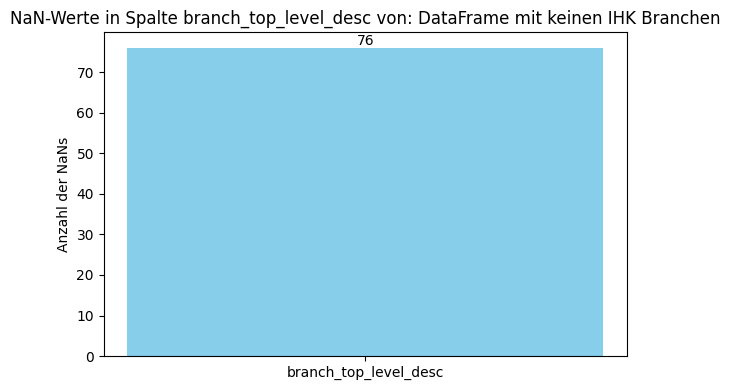

In [21]:
df_no_ihk_branch = df[df['ihk_branch_id'].isna() | df['ihk_branch_desc'].isna()]
df_no_ihk_branch.name = "DataFrame mit keinen IHK Branchen"
visualize_nan(df_no_ihk_branch, "branch_top_level_desc")

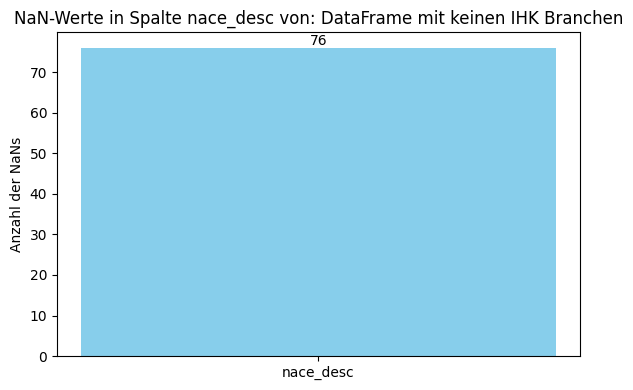

In [22]:
visualize_nan(df_no_ihk_branch, "nace_desc")

In [23]:
df.drop(df[df['ihk_branch_id'].isna() | df['ihk_branch_desc'].isna()].index, inplace=True)

In [24]:
df[df["ihk_branch_desc"].isna() | df["ihk_branch_id"].isna()]

Empty DataFrame
Columns: [opendata_id, city, postcode, latitude, longitude, ihk_branch_id, nace_id, branch_top_level_id, employees_range, ihk_branch_desc, nace_desc, branch_top_level_desc, business_age, business_type, Bezirk, planungsraum_id, Planungsraum, Bezirksregion, Prognoseraum, Ortsteil]
Index: []

Jetzt haben alle Daten einen IHK Branchen Beschreibung

## Bezirk, Ortsteil & co.

In [25]:
missing_areas = df[df["Bezirk"].isna() | df["Ortsteil"].isna() | df["Prognoseraum"].isna() | df["Bezirksregion"].isna() | df["Planungsraum"].isna()]
missing_areas

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
49306    296485567852  Berlin     12529  52.385956  13.489473         5310.0   
185670  1109202071340  Berlin     14057  52.503453  13.290048        56210.0   
199567   113122567752  Berlin     12277  52.419711  13.391696       662200.0   
212952  1192706471688  Berlin     14165  52.409737  13.259260      7490017.0   
220311   115215187506  Berlin     13347  52.548844  13.365961        27400.0   
222252   117558667622  Berlin     14163  52.437316  13.233795        56105.0   
246850   120907867262  Berlin     10437  52.546597  13.418634       472900.0   
255660   123071227374  Berlin     12526  52.396280  13.535811        52239.0   
258086    12420156752  Berlin     13347  52.548844  13.365961         9609.0   
267967   124925587186  Berlin     12526  52.396280  13.535811       855301.0   
275203  1251346871156  Berlin     12049  52.473912  13.427565       741021.0   
303379   129316387546  Berlin     12526  52.396280  13.535811        56103.0   
317497   131238007600  Berlin     10119  52.528618  13.407053         9609.0   
319239  1306686671622  Berlin     13357  52.544119  13.375374       432911.0   

        nace_id  branch_top_level_id     employees_range  \
49306    5310.0                 53.0      0 Beschäftigte   
185670   5621.0                 56.0      0 Beschäftigte   
199567   6622.0                 66.0      0 Beschäftigte   
212952   7490.0                 74.0      0 Beschäftigte   
220311   2740.0                 27.0      0 Beschäftigte   
222252   5610.0                 56.0  7 - 9 Beschäftigte   
246850   4729.0                 47.0      0 Beschäftigte   
255660   5223.0                 52.0      0 Beschäftigte   
258086   9609.0                 96.0           unbekannt   
267967   8553.0                 85.0      0 Beschäftigte   
275203   7410.0                 74.0      0 Beschäftigte   
303379   5610.0                 56.0      0 Beschäftigte   
317497   9609.0                 96.0           unbekannt   
319239   4329.0                 43.0      0 Beschäftigte   

                                          ihk_branch_desc  \
49306    Postdienste v. Universaldienstleistungsanbietern   
185670                                      Event-Caterer   
199567                             Versicherungsvertreter   
212952                                  Fotomodell, Model   
220311              H. v. elektrischen Lampen u. Leuchten   
222252                                          Eissalons   
246850                                EH m. Kaffee, Kakao   
255660  Erbringung v. sonstigen Dienstleistungen f. di...   
258086  Erbringung v. sonstigen Dienstleistungen a. n. g.   
267967          Flug-, Bootsführer-, Segel-  u.ä. Schulen   
275203                               Grafik- / Fotodesign   
303379                                  Imbissstuben u.ä.   
317497  Erbringung v. sonstigen Dienstleistungen a. n. g.   
319239                             Akustik- u. Trockenbau   

                                                nace_desc  \
49306    Postdienste v. Universaldienstleistungsanbietern   
185670                                      Event-Caterer   
199567  Tätigkeit v. Versicherungsmaklerinnen u. -maklern   
212952  Sonstige freiberufliche, wissenschaftliche u. ...   
220311              H. v. elektrischen Lampen u. Leuchten   
222252  Restaurants, Gaststätten, Imbissstuben, Cafés,...   
246850  Sonstiger Einzelhandel m. Nahrungs- u. Genussm...   
255660  Erbringung v. sonstigen Dienstleistungen f. di...   
258086  Erbringung v. sonstigen Dienstleistungen a. n. g.   
267967                               Fahr- u. Flugschulen   
275203  Ateliers f. Textil-, Schmuck-, Grafik- u. ä. D...   
303379  Restaurants, Gaststätten, Imbissstuben, Cafés,...   
317497  Erbringung v. sonstigen Dienstleistungen a. n. g.   
319239                           Sonstige Bauinstallation   

                                    branch_top_level_desc  business_age  \
4

In [26]:
center_lat = missing_areas["latitude"].mean()
center_lon = missing_areas["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)

for index, row in missing_areas.iterrows():
    popup_text = f"opendata_id: {row['opendata_id']}"
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_text,
        icon=folium.Icon(color='red')
    ).add_to(marker_cluster)

m

# m.save("missing_areas_map.html")

- opendata_id: 296785567852 droppen, weil dieser nicht in Berlin ist sondern in Schönefeld

In [27]:
df.drop(df[df["opendata_id"] == 296785567852].index, inplace=True)

In [28]:
df.drop(missing_areas.index, inplace=True)

## employees_range

In [29]:
df["employees_range"].value_counts()

employees_range
0 Beschäftigte                 236971
1 - 3 Beschäftigte              81351
4 - 6 Beschäftigte              13629
unbekannt                        9826
10 - 19 Beschäftigte             8384
7 - 9 Beschäftigte               5885
20 - 49 Beschäftigte             5796
50 - 99 Beschäftigte             2056
100 - 199 Beschäftigte           1080
200 - 499 Beschäftigte            642
500 - 999 Beschäftigte            184
1000 - 2499 Beschäftigte          126
2500 - 4999 Beschäftigte           33
5000 - 7499 Beschäftigte           14
10000 und mehr Beschäftigte         7
7500 - 9999 Beschäftigte            7
Name: count, dtype: int64

In [30]:
df.drop(df[df["employees_range"] == "unbekannt"].index, inplace=True)

In [31]:
# (x1 + x2)/2
mapping = {
    "0 Beschäftigte": 0.0,
    "1 - 3 Beschäftigte": 2.0,
    "4 - 6 Beschäftigte": 5.0,
    "7 - 9 Beschäftigte": 8.0,
    "10 - 19 Beschäftigte": 14.5,
    "20 - 49 Beschäftigte": 34.5,
    "50 - 99 Beschäftigte": 74.5,
    "100 - 199 Beschäftigte": 149.5, 
    "200 - 499 Beschäftigte": 349.5,
    "500 - 999 Beschäftigte": 749.5,
    "1000 - 2499 Beschäftigte": 1749.5,
    "2500 - 4999 Beschäftigte": 3749.5,
    "5000 - 7499 Beschäftigte": 6249.5,
    "7500 - 9999 Beschäftigte": 8749.5,
    "10000 und mehr Beschäftigte": 12500.0
}

In [32]:
df["employees_numerical"] = df["employees_range"].map(mapping)

In [33]:
df["employees_numerical"].describe()

count    356165.000000
mean          5.213275
std          95.427335
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max       12500.000000
Name: employees_numerical, dtype: float64

## business_age

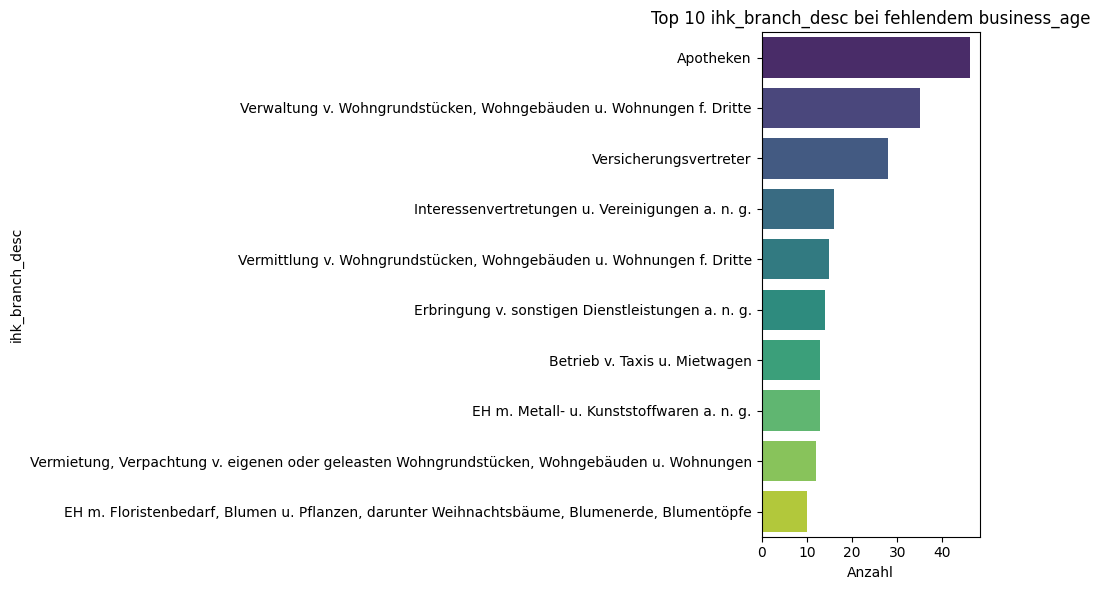

In [34]:
# 1) Filter: Zeilen, in denen 'business_age' fehlt
df_missing_age = df[df['business_age'].isna()]

# 2) Top 10 ihk_branch_desc ermitteln (nach Häufigkeit)
top10_branches_missing_age = df_missing_age['ihk_branch_desc'].value_counts().head(10)

# 3) Zur besseren Darstellung in ein Hilfs-DataFrame überführen
temp_df = top10_branches_missing_age.reset_index()
temp_df.columns = ['ihk_branch_desc', 'Count']

# 4) Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
sns.barplot(data=temp_df, x='Count', y='ihk_branch_desc', hue='ihk_branch_desc', palette='viridis')
plt.xlabel("Anzahl")
plt.ylabel("ihk_branch_desc")
plt.title("Top 10 ihk_branch_desc bei fehlendem business_age")
plt.tight_layout()
plt.show()

<Figure size 1200x1200 with 0 Axes>

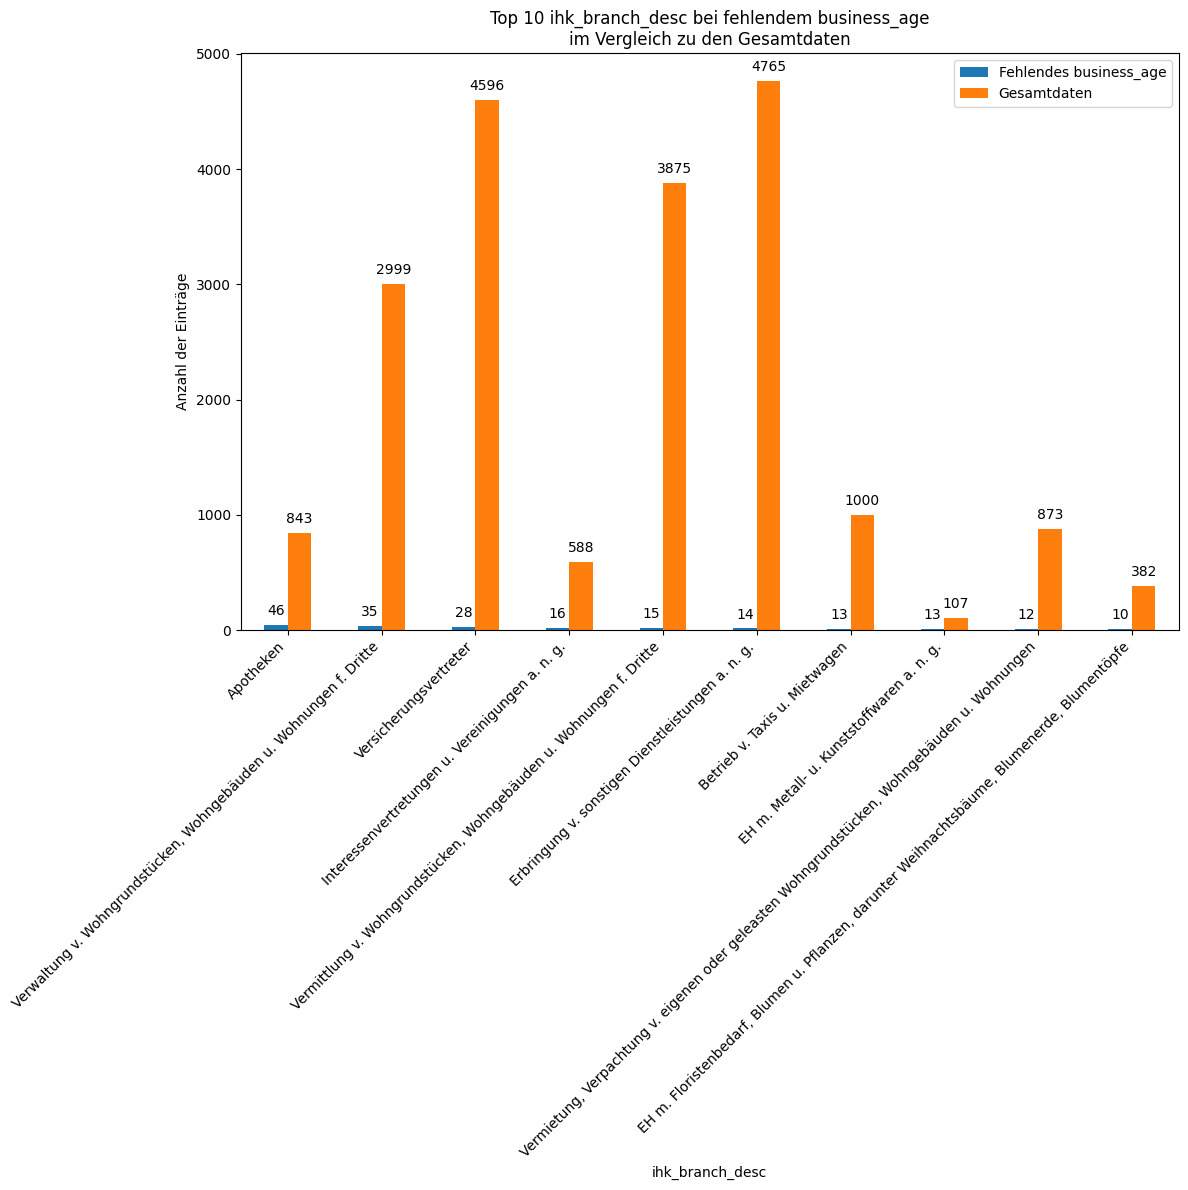

In [35]:
# 1) Filtere die Zeilen, in denen business_age fehlt
df_missing = df[df['business_age'].isna()]

# 2) Ermittle die Top 10 ihk_branch_desc aus dem Subset mit fehlendem business_age
top10_branches = df_missing['ihk_branch_desc'].value_counts().head(10).index

# 3) Berechne die Häufigkeiten für diese Top 10 in beiden Datensätzen:
#    a) im Subset (business_age fehlt)
missing_counts = df_missing['ihk_branch_desc'].value_counts().loc[top10_branches]
#    b) im gesamten DataFrame
total_counts = df['ihk_branch_desc'].value_counts().loc[top10_branches]

# 4) Kombiniere die beiden Serien in ein DataFrame, um einen Vergleich zu ermöglichen
df_counts = pd.DataFrame({
    'Fehlendes business_age': missing_counts,
    'Gesamtdaten': total_counts
})

# Optional: Sortiere nach der Häufigkeit im Subset
df_counts = df_counts.sort_values('Fehlendes business_age', ascending=False)

# 5) Erstelle einen gruppierten Balkendiagramm-Vergleich
plt.figure(figsize=(12, 12))
ax = df_counts.plot(kind='bar', figsize=(12,12))
ax.set_xlabel('ihk_branch_desc')
ax.set_ylabel('Anzahl der Einträge')
ax.set_title('Top 10 ihk_branch_desc bei fehlendem business_age\nim Vergleich zu den Gesamtdaten')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 6) Zahlen in jedem Balken anzeigen
for patch in ax.patches:
    # Erhalte die Höhe des Balkens (also den jeweiligen Wert)
    height = patch.get_height()
    # Füge den Text (gerundet) mittig oben im Balken ein, mit einem kleinen Offset (5 Punkte)
    ax.annotate(f'{int(height)}',
                (patch.get_x() + patch.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

In [36]:
df.dropna(subset=["business_age"], inplace=True)
print(df["business_age"].describe())
print(df["business_age"].isna().sum())

count    355273.000000
mean          9.487718
std           9.660730
min           0.000000
25%           2.000000
50%           7.000000
75%          14.000000
max         100.000000
Name: business_age, dtype: float64
0


In [37]:
# Umwandeln in ein datetime-Objekt und das Jahr extrahieren
base_year = pd.to_datetime(IHK_GEWERBEDATEN_DATE).year  # ergibt 2025

# Neue Spalte 'gründungsjahr' erstellen: Gründungsjahr = Basisjahr - business_age
df['gründungsjahr'] = (base_year - df['business_age']).astype(int)

print(base_year)

df[["gründungsjahr", "business_age"]].head()

2025


gründungsjahr  business_age
0           1985          40.0
1           1984          41.0
2           1985          40.0
3           2012          13.0
4           2015          10.0

In [38]:
corr = df[['business_age', 'employees_numerical']].corr().iloc[0, 1]
print("Korrelationskoeffizient:", corr)

Korrelationskoeffizient: 0.053686462805119045


In [39]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts

nace_desc                259
branch_top_level_desc    219
business_age               0
employees_numerical        0
Ortsteil                   0
Prognoseraum               0
Bezirksregion              0
Planungsraum               0
planungsraum_id            0
Bezirk                     0
business_type              0
opendata_id                0
city                       0
ihk_branch_desc            0
employees_range            0
branch_top_level_id        0
nace_id                    0
ihk_branch_id              0
longitude                  0
latitude                   0
postcode                   0
gründungsjahr              0
dtype: int64

Auf die restlichen Werte, kann verzichtet werden, da sie für das Clustering nicht relevant sind

In [40]:
df.drop(columns=["nace_id", "branch_top_level_id", "nace_desc", "branch_top_level_desc"], axis=1, inplace=True)

In [41]:
df.head()

opendata_id    city  postcode   latitude  longitude  ihk_branch_id  \
0        572114  Berlin     10179  52.513315  13.411584        65122.0   
1       6063606  Berlin     10713  52.488737  13.302834       562900.0   
2     131831318  Berlin     10713  52.479296  13.319051        47430.0   
3  943032071440  Berlin     12047  52.486200  13.429312       731108.0   
4  927439271464  Berlin     12435  52.492207  13.451324       451103.0   

      employees_range                            ihk_branch_desc  \
0      0 Beschäftigte           Schaden- u. Unfallversicherungen   
1      0 Beschäftigte                                   Kantinen   
2      0 Beschäftigte  EH m. Geräten der Unterhaltungselektronik   
3      0 Beschäftigte                  Promotion, Propagandisten   
4  1 - 3 Beschäftigte   EH m. Elektro-, Gas- u. Hybridfahrzeugen   

   business_age                   business_type                      Bezirk  \
0          40.0          Kleingewerbetreibender                       Mitte   
1          41.0          Kleingewerbetreibender  Charlottenburg-Wilmersdorf   
2          40.0          Kleingewerbetreibender  Charlottenburg-Wilmersdorf   
3          13.0  im Handelsregister eingetragen                    Neukölln   
4          10.0          Kleingewerbetreibender            Treptow-Köpenick   

   planungsraum_id        Planungsraum          Bezirksregion  \
0        1100312.0  Heine-Viertel West         Alexanderplatz   
1        4500939.0     Eisenzahnstraße               Halensee   
2        4501148.0     Brabanter Platz  Volkspark Wilmersdorf   
3        8100314.0         Donaustraße           Reuterstraße   
4        9100101.0         Alt-Treptow            Alt-Treptow   

          Prognoseraum     Ortsteil  employees_numerical  gründungsjahr  
0              Zentrum        Mitte                  0.0           1985  
1  Wilmersdorf Zentrum  Wilmersdorf                  0.0           1984  
2  Wilmersdorf Zentrum  Wilmersdorf                  0.0           1985  
3             Neukölln     Neukölln                  0.0           2012  
4   Treptow-Köpenick 1  Alt-Treptow                  2.0           2015

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 355273 entries, 0 to 366088
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   opendata_id          355273 non-null  int64  
 1   city                 355273 non-null  object 
 2   postcode             355273 non-null  int64  
 3   latitude             355273 non-null  float64
 4   longitude            355273 non-null  float64
 5   ihk_branch_id        355273 non-null  float64
 6   employees_range      355273 non-null  object 
 7   ihk_branch_desc      355273 non-null  object 
 8   business_age         355273 non-null  float64
 9   business_type        355273 non-null  object 
 10  Bezirk               355273 non-null  object 
 11  planungsraum_id      355273 non-null  float64
 12  Planungsraum         355273 non-null  object 
 13  Bezirksregion        355273 non-null  object 
 14  Prognoseraum         355273 non-null  object 
 15  Ortsteil             3

In [ ]:
df.to_csv("../input/ihk_gewerbedaten_clean.csv", index=False)